In [ ]:
# Data manipulation
from os import path
import numpy as np
import pandas as pd
from itertools import groupby
import os
import csv
import glob
import tifffile

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.colors import ListedColormap
import seaborn as sns

# Images manipulation
from skimage import img_as_float, img_as_ubyte, exposure, feature, morphology, measure, segmentation, transform, color
from skimage.restoration import denoise_nl_means, unsupervised_wiener, denoise_tv_bregman, denoise_bilateral
from skimage.util import compare_images, invert
from skimage.filters import threshold_multiotsu, difference_of_gaussians
from skimage.morphology import disk
from skimage.io import imread
from scipy import stats, misc, ndimage
import cv2

# Machine learning
import pickle
from keras.models import Model
from keras.applications.vgg16 import VGG16
import xgboost as xgb

In [3]:
# CNN - Features extraction
path = r"C:\Users\teolo\Documents\Teo\Codes\New\SEM-segmentation and particle reconition\Tomo"

train_images = []
train_masks = []

path_train = path + "\\Training"
path_mask = path + "\\Mask"

for directory_path in glob.glob(path_train):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        
for directory_path in glob.glob(path_mask):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)
        train_masks.append(mask)
        
train_images = np.array(train_images)
train_masks = np.array(train_masks)

X_Train = train_images
Y_train = train_masks
y_train = np.expand_dims(Y_train, axis=3)

VGG_model = VGG16(weights="imagenet", include_top=False, input_shape=(len(train_images[0]), len(train_images[0][0]), 3))
#VGG_model.summary()

for layer in VGG_model.layers:
    layer.trainable = False
#VGG_model.summary()

CNN_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer("block1_conv2").output)   
#CNN_model.summary()

features_CNN = CNN_model.predict(X_Train)

1/1 [==============================] - 3s 3s/step


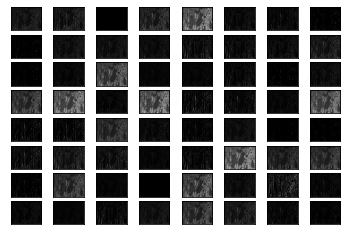

In [4]:
# Watching CNN Features
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features_CNN[4,:,:,ix-1], cmap="gray")
        ix+=1
plt.show()

In [5]:
# Creating and cleaning dataset for RF
X = features_CNN
X = X.reshape(-1, X.shape[3])
Y = y_train.reshape(-1)
    
dataset = pd.DataFrame(X)

In [6]:
# Adding personal Gabbor feature and labels
train_images_bw = []

for i in range(len(train_images)):
    grey = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2GRAY)
    train_images_bw.append(grey)

#train_images_bw = np.array(train_images_bw)

# Gabor filter
ksize_Gabor = 90
theta=np.pi/3
kernel = cv2.getGaborKernel((ksize_Gabor,ksize_Gabor), 1.0, theta, 10.0, 1.9, 0, ktype=cv2.CV_32F)

Gabor_filtered = []
for img_bw in train_images_bw:
    filtered_image = cv2.filter2D(img_bw,cv2.CV_8UC1, kernel)
    Gabor_filtered.append(filtered_image)
    
Gabor_filtered = np.array(Gabor_filtered)

Gabor_filtered = Gabor_filtered.reshape(-1)

dataset["64"] = Gabor_filtered
dataset["Label"] = Y

dataset = dataset[dataset["Label"] != 0]

print(dataset["Label"].value_counts()) # In this case 3 is SE, 1 AM, and 2 pores (same order of Apeer)

3    1671284
1     672267
2      91088
Name: Label, dtype: int64


In [24]:
# Balancing dataset
from sklearn.utils import resample

dataset1 = dataset[dataset["Label"] == 1]
dataset2 = dataset[dataset["Label"] == 2]
dataset3 = dataset[dataset["Label"] == 3]

counts_labels = [dataset["Label"].value_counts()[1], dataset["Label"].value_counts()[2], dataset["Label"].value_counts()[3]]
average_labels = int(round(np.average(counts_labels), -2))

# Upsample minority class and other classes separately
# If not, random samples from combined classes will be duplicated and we run into
#same issue as before, undersampled remians undersampled.
df1 = resample(dataset1, 
                                 replace=True,     # sample with replacement
                                 n_samples=average_labels,    # to match average class
                                 random_state=21) # reproducible results
 
df2 = resample(dataset2, 
                                 replace=True,     # sample with replacement
                                 n_samples=average_labels,    # to match average class
                                 random_state=21) # reproducible results

df3 = resample(dataset3, 
                                 replace=True,     # sample with replacement
                                 n_samples=average_labels,    # to match average class
                                 random_state=21) # reproducible results

dataset_resampled = pd.concat([df1, df2, df3])
print(dataset_resampled['Label'].value_counts())

1    811500
2    811500
3    811500
Name: Label, dtype: int64


In [51]:
# Xgboost semantic classification model
X_XB = dataset.drop(labels=["Label"], axis=1)
Y_XB = dataset["Label"]

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.metrics import MeanIoU

Y_XB = LabelEncoder().fit_transform(Y_XB)

X_train_XB, X_test_XB, Y_train_XB, Y_test_XB = train_test_split(X_XB, Y_XB, test_size=0.2, random_state=21)

# Training
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_XB, Y_train_XB)

# Save model 
path_pickle = path + "\\XBoost_semantic_model.pickle"
with open(path_pickle, 'wb') as file:
    pickle.dump(xgb_model, file)

# Validation
prediction_XB = xgb_model.predict(X_test_XB)
accuracy = metrics.accuracy_score(Y_test_XB, prediction_XB)
print("Overall accuracy = ", accuracy)

#IoU
num_classes = 3
IoU_XB = MeanIoU(num_classes=num_classes)
IoU_XB.update_state(Y_test_XB, prediction_XB)
IoU_results = IoU_XB.result().numpy()
print("IoU overall = ", IoU_results)

weights = np.array(IoU_XB.get_weights()).reshape(num_classes, num_classes)
print(weights)
class1_IoU = weights[0,0]/(weights[0,0] + weights[0,1] + weights[0,2] + weights[1,0]+ weights[2,0])
class2_IoU = weights[1,1]/(weights[1,1] + weights[1,0] + weights[1,2] + weights[0,1]+ weights[2,1])
class3_IoU = weights[2,2]/(weights[2,2] + weights[2,0] + weights[2,1] + weights[0,2]+ weights[1,2])

print("IoU for AM is: ", class1_IoU)
print("IoU for pores is: ", class2_IoU)
print("IoU for SE is: ", class3_IoU)

[1 3 2]
Overall accuracy =  0.9243194065652417


AttributeError: 'MeanIoU' object has no attribute 'results'

In [53]:
IoU_results = IoU_XB.result().numpy()
print("IoU overall = ", IoU_results)
weights = np.array(IoU_XB.get_weights()).reshape(num_classes, num_classes)
print(weights)
class1_IoU = weights[0,0]/(weights[0,0] + weights[0,1] + weights[0,2] + weights[1,0]+ weights[2,0])
class2_IoU = weights[1,1]/(weights[1,1] + weights[1,0] + weights[1,2] + weights[0,1]+ weights[2,1])
class3_IoU = weights[2,2]/(weights[2,2] + weights[2,0] + weights[2,1] + weights[0,2]+ weights[1,2])

print("IoU for AM is: ", class1_IoU)
print("IoU for pores is: ", class2_IoU)
print("IoU for SE is: ", class3_IoU)

IoU overall =  0.8005262
[[1.18697e+05 2.92000e+02 1.55610e+04]
 [4.78000e+02 1.43070e+04 3.72600e+03]
 [1.56090e+04 1.18500e+03 3.17073e+05]]
IoU for AM is:  0.7879671
IoU for pores is:  0.7157795
IoU for SE is:  0.8978321


1/1 [==============================] - 1s 522ms/step


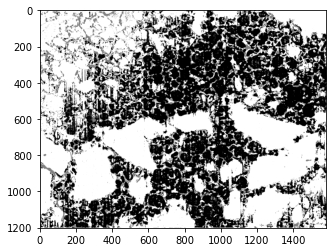

In [66]:
# Checking with respect to test image(s)
path = r"C:\Users\teolo\Documents\Teo\Codes\New\SEM-segmentation and particle reconition\Tomo"

path_test = path + "\\Test"

tests = os.listdir(path_test)

for img_t in tests:
    if ".png" in img_t:
        path_img_t = path_test + "\\" + str(img_t)
        test_img = cv2.imread(path_img_t, cv2.IMREAD_COLOR)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
                
        grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

        # Gabor filter
        ksize_Gabor = 90
        theta=np.pi/3
        kernel = cv2.getGaborKernel((ksize_Gabor,ksize_Gabor), 1.0, theta, 10.0, 1.9, 0, ktype=cv2.CV_32F)

        filtered_image = cv2.filter2D(grey,cv2.CV_8UC1, kernel)

        filtered_image = np.array(filtered_image)

        filtered_image = filtered_image.reshape(-1)
        
        test_img = np.expand_dims(test_img, axis=0)
        
        X_test_feature = CNN_model.predict(test_img)
        X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
        dataset_test = pd.DataFrame(X_test_feature)
        dataset_test["64"] = filtered_image
        
        prediction_test = xgb_model.predict(dataset_test)
        
        # View and save predicted image
        prediction_image = prediction_test.reshape(mask.shape)
        plt.imshow(prediction_image, cmap="gray")
        path_save = path_test + "\\Segmented_" + str(img_t)
        plt.imsave(path_save, prediction_image, cmap="gray")

In [ ]:
### https://www.youtube.com/watch?v=vgdFovAZUzM&list=PLZsOBAyNTZwbIjGnolFydAN33gyyGP7lT&index=164